In [124]:
#import statements
import numpy as np
import pandas as pd
import json
import requests
from operator import itemgetter

import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer

### Data Loading

Data sourced from https://www.kaggle.com/datasets/nikdavis/steam-store-games?select=steamspy_tag_data.csv

The author of the dataset documented their process of using Steam APIs here:
https://nik-davis.github.io/posts/2019/steam-data-collection/

The dataset is stored under a data folder in my local repository. 

The filepath is ./data/Steam_store_data

There are 6 CSV files in the dataset.

In [2]:
!ls

API_calls.ipynb
README.md
Steam API Calls.txt
SteamWebAPIKey.txt
Steam_API_Owned_Games.json
data
notebook.ipynb
scratch_notebook.ipynb


In [3]:
steam_df = pd.read_csv('./data/Steam_store_data/steam.csv')

In [4]:
steam_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27075 entries, 0 to 27074
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   appid             27075 non-null  int64  
 1   name              27075 non-null  object 
 2   release_date      27075 non-null  object 
 3   english           27075 non-null  int64  
 4   developer         27075 non-null  object 
 5   publisher         27075 non-null  object 
 6   platforms         27075 non-null  object 
 7   required_age      27075 non-null  int64  
 8   categories        27075 non-null  object 
 9   genres            27075 non-null  object 
 10  steamspy_tags     27075 non-null  object 
 11  achievements      27075 non-null  int64  
 12  positive_ratings  27075 non-null  int64  
 13  negative_ratings  27075 non-null  int64  
 14  average_playtime  27075 non-null  int64  
 15  median_playtime   27075 non-null  int64  
 16  owners            27075 non-null  object

### Exploring the data

In [5]:
steam_df.shape

(27075, 18)

There are 27,705 rows - each representing a game in Steam's store - and 18 columns.

Let's go through each column one-by-one:

In [6]:
#unique id value identifier for game
steam_df['appid']

0             10
1             20
2             30
3             40
4             50
          ...   
27070    1065230
27071    1065570
27072    1065650
27073    1066700
27074    1069460
Name: appid, Length: 27075, dtype: int64

In [7]:
#name of game
steam_df['name']

0                    Counter-Strike
1             Team Fortress Classic
2                     Day of Defeat
3                Deathmatch Classic
4         Half-Life: Opposing Force
                    ...            
27070               Room of Pandora
27071                     Cyber Gun
27072              Super Star Blast
27073    New Yankee 7: Deer Hunters
27074                     Rune Lord
Name: name, Length: 27075, dtype: object

In [8]:
#date of release (YY-MM-DD)
steam_df['release_date']

0        2000-11-01
1        1999-04-01
2        2003-05-01
3        2001-06-01
4        1999-11-01
            ...    
27070    2019-04-24
27071    2019-04-23
27072    2019-04-24
27073    2019-04-17
27074    2019-04-24
Name: release_date, Length: 27075, dtype: object

In [9]:
#release_date is stored as a string
type(steam_df['release_date'][0])

str

In [10]:
steam_df['release_date'].max()

'2019-05-01'

In [11]:
steam_df['english']

0        1
1        1
2        1
3        1
4        1
        ..
27070    1
27071    1
27072    1
27073    1
27074    1
Name: english, Length: 27075, dtype: int64

In [12]:
steam_df['english'].value_counts()

1    26564
0      511
Name: english, dtype: int64

There are 26,564 English games and 511 non-English games.

In [13]:
#name of game's developer
steam_df['developer']

0                     Valve
1                     Valve
2                     Valve
3                     Valve
4          Gearbox Software
                ...        
27070           SHEN JIAWEI
27071        Semyon Maximov
27072           EntwicklerX
27073    Yustas Game Studio
27074      Adept Studios GD
Name: developer, Length: 27075, dtype: object

In [14]:
#name of game's publisher
steam_df['publisher']

0                       Valve
1                       Valve
2                       Valve
3                       Valve
4                       Valve
                 ...         
27070             SHEN JIAWEI
27071        BekkerDev Studio
27072             EntwicklerX
27073    Alawar Entertainment
27074    Alawar Entertainment
Name: publisher, Length: 27075, dtype: object

In [15]:
#platform availability for game
steam_df['platforms']

0        windows;mac;linux
1        windows;mac;linux
2        windows;mac;linux
3        windows;mac;linux
4        windows;mac;linux
               ...        
27070              windows
27071              windows
27072              windows
27073          windows;mac
27074          windows;mac
Name: platforms, Length: 27075, dtype: object

In [16]:
steam_df['platforms'].value_counts()

windows              18398
windows;mac;linux     4623
windows;mac           3439
windows;linux          610
mac                      3
linux                    1
mac;linux                1
Name: platforms, dtype: int64

In [17]:
steam_df[steam_df['platforms'] == 'mac']

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
1413,214630,Call of Duty: Black Ops - Mac Edition,2012-09-27,1,Aspyr,Aspyr,mac,18,Single-player;Multi-player;Co-op;Steam Achieve...,Action,Action;Zombies;Multiplayer,68,168,105,0,0,50000-100000,15.49
12479,569050,Paul Pixel - The Awakening,2017-01-09,1,Xoron GmbH,Xoron GmbH,mac,0,Single-player,Adventure;Indie,Adventure;Indie;Point & Click,0,5,0,0,0,0-20000,2.89
16662,694180,MobileZombie,2017-10-13,1,YIMING ZHANG,YIMING ZHANG,mac,0,Single-player;Partial Controller Support,Adventure;Casual;Free to Play;Indie,Free to Play;Adventure;Indie,0,14,11,0,0,0-20000,0.00


In [18]:
#age-requirement for game
steam_df['required_age']

0        0
1        0
2        0
3        0
4        0
        ..
27070    0
27071    0
27072    0
27073    0
27074    0
Name: required_age, Length: 27075, dtype: int64

In [19]:
steam_df['required_age'].value_counts()

0     26479
18      308
16      192
12       73
7        12
3        11
Name: required_age, dtype: int64

In [20]:
steam_df['categories']

0        Multi-player;Online Multi-Player;Local Multi-P...
1        Multi-player;Online Multi-Player;Local Multi-P...
2                    Multi-player;Valve Anti-Cheat enabled
3        Multi-player;Online Multi-Player;Local Multi-P...
4        Single-player;Multi-player;Valve Anti-Cheat en...
                               ...                        
27070                     Single-player;Steam Achievements
27071                                        Single-player
27072    Single-player;Multi-player;Co-op;Shared/Split ...
27073                            Single-player;Steam Cloud
27074                            Single-player;Steam Cloud
Name: categories, Length: 27075, dtype: object

In [21]:
#there are a lot of combinations for categories
#might have to clean this up separately to see pull out the most meaningful categories
steam_df['categories'].value_counts()

Single-player                                                                                                                                                                                                      6110
Single-player;Steam Achievements                                                                                                                                                                                   2334
Single-player;Steam Achievements;Steam Trading Cards                                                                                                                                                                848
Single-player;Partial Controller Support                                                                                                                                                                            804
Single-player;Steam Trading Cards                                                                                                       

In [22]:
def extract_category(df, column):
    '''
    Returns a dictionary containing categories and their counts from the dataframe
    Categories and genres are stored separated by a semicolon
    '''
    category_dict = {}
    for tags in df[column]:
        split_tags = tags.split(';')
        for x in split_tags:
            if x not in category_dict:
                category_dict[x] = 1
            else:
                category_dict[x] += 1
    return category_dict

In [23]:
categories = extract_category(steam_df, 'categories')
categories

{'Multi-player': 3974,
 'Online Multi-Player': 2487,
 'Local Multi-Player': 1615,
 'Valve Anti-Cheat enabled': 94,
 'Single-player': 25678,
 'Steam Cloud': 7219,
 'Steam Achievements': 14130,
 'Steam Trading Cards': 7918,
 'Captions available': 721,
 'Partial Controller Support': 4234,
 'Includes Source SDK': 35,
 'Cross-Platform Multiplayer': 1081,
 'Stats': 1878,
 'Commentary available': 144,
 'Includes level editor': 1036,
 'Steam Workshop': 897,
 'In-App Purchases': 690,
 'Co-op': 1721,
 'Full controller support': 5695,
 'Steam Leaderboards': 3439,
 'SteamVR Collectibles': 40,
 'Online Co-op': 1071,
 'Shared/Split Screen': 2152,
 'Local Co-op': 1059,
 'MMO': 421,
 'VR Support': 231,
 'Mods': 2,
 'Mods (require HL2)': 1,
 'Steam Turn Notifications': 63}

In [24]:
#maybe subset categories based on number of players
categories_players = ['Multi-player', 'Online Multi-Player', 'Local Multi-Player', 'Single-player', 'Co-op', 'Online Co-op', 'Shared/Split Screen', 'Local Co-op']
subset_categories = [x for x in categories if x in categories_players]
subset_categories

['Multi-player',
 'Online Multi-Player',
 'Local Multi-Player',
 'Single-player',
 'Co-op',
 'Online Co-op',
 'Shared/Split Screen',
 'Local Co-op']

In [25]:
steam_df[steam_df['categories'] == 'Multi-player']

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
811,42980,Victoria I Complete,2010-08-20,1,Paradox Development Studio,Paradox Interactive,windows,0,Multi-player,Strategy,Strategy;Grand Strategy;Real-Time with Pause,0,88,41,17,17,100000-200000,7.99
812,42990,Sword of the Stars II: Enhanced Edition,2012-11-30,1,Kerberos Productions,Paradox Interactive,windows,0,Multi-player,Strategy,Strategy;4X;Space,14,335,448,38,74,100000-200000,14.99
1438,215870,Dungeon-Party,2013-03-13,1,Cyanide Studio,Bigben Interactive,windows,0,Multi-player,Free to Play;Massively Multiplayer,Free to Play;Massively Multiplayer;Multiplayer,20,154,231,1,1,200000-500000,0.00
1885,246820,Jeklynn Heights,2016-05-25,1,"Vex Studios, LLC","Vex Studios, LLC",windows,0,Multi-player,Action;Adventure;Casual;Indie;Early Access,Early Access;Action;Adventure,0,14,4,0,0,0-20000,0.00
2618,278970,Digger Online,2015-06-02,1,DiggerWorld Ltd.,DiggerWorld Ltd.,windows,0,Multi-player,Action;Adventure,Story Rich;Action;Atmospheric,0,8700,10498,56,24,200000-500000,6.99
4653,344760,Reign Of Kings,2015-12-15,1,Code}{atch,Code}{atch,windows,0,Multi-player,Action;Adventure;Indie;RPG;Simulation,Survival;Open World;Medieval,0,8076,5997,3498,3322,200000-500000,7.19
4991,353130,Time of Dragons,2016-02-01,1,4 I Lab,4 I Lab,windows;mac;linux,0,Multi-player,Action;Free to Play;Indie;Massively Multiplaye...,Dragons;Free to Play;Flight,120,1095,560,19,20,500000-1000000,0.00
5028,354560,We Are Legion,2015-08-07,1,Pwnee Studios,Pwnee Studios,windows;mac;linux,0,Multi-player,Indie;Strategy,Strategy;Indie,0,48,73,0,0,0-20000,6.99
5049,355070,TDP5 Arena 3D,2015-03-26,1,Javelin OÜ,Javelin OÜ,windows,0,Multi-player,Action;Free to Play;Massively Multiplayer,Free to Play;Action;Massively Multiplayer,0,99,119,8,8,100000-200000,0.00
6355,389570,Mitos.is: The Game,2015-07-29,1,Freakinware Studios,Freakinware Studios,windows;mac,0,Multi-player,Free to Play;Simulation,Free to Play;Multiplayer;Massively Multiplayer,0,9463,2158,268,67,2000000-5000000,0.00


In [26]:
steam_df['genres'].value_counts()

Action;Indie                                                          1852
Casual;Indie                                                          1482
Action;Adventure;Indie                                                1229
Adventure;Indie                                                       1170
Action;Casual;Indie                                                   1004
                                                                      ... 
Massively Multiplayer;Early Access                                       1
Simulation;Education;Software Training                                   1
Action;Free to Play;Racing;Sports                                        1
Violent;Gore;Action;Casual;Indie;Strategy;Early Access                   1
Violent;Gore;Action;Adventure;Indie;Racing;RPG;Simulation;Strategy       1
Name: genres, Length: 1552, dtype: int64

In [27]:
genre_dict = extract_category(steam_df, 'genres')
genre_dict

{'Action': 11903,
 'Free to Play': 1704,
 'Strategy': 5247,
 'Adventure': 10032,
 'Indie': 19421,
 'RPG': 4311,
 'Animation & Modeling': 79,
 'Video Production': 38,
 'Casual': 10210,
 'Simulation': 5194,
 'Racing': 1024,
 'Violent': 843,
 'Massively Multiplayer': 723,
 'Nudity': 266,
 'Sports': 1322,
 'Early Access': 2954,
 'Gore': 537,
 'Utilities': 146,
 'Design & Illustration': 87,
 'Web Publishing': 28,
 'Education': 51,
 'Software Training': 31,
 'Sexual Content': 245,
 'Audio Production': 29,
 'Game Development': 17,
 'Photo Editing': 12,
 'Accounting': 6,
 'Documentary': 1,
 'Tutorial': 1}

Some of these items aren't games; some are developer tools or asset packs. I'll focus on popular genres to deliver generalized results. 

In [28]:
genres = list(genre_dict.keys())
genres

['Action',
 'Free to Play',
 'Strategy',
 'Adventure',
 'Indie',
 'RPG',
 'Animation & Modeling',
 'Video Production',
 'Casual',
 'Simulation',
 'Racing',
 'Violent',
 'Massively Multiplayer',
 'Nudity',
 'Sports',
 'Early Access',
 'Gore',
 'Utilities',
 'Design & Illustration',
 'Web Publishing',
 'Education',
 'Software Training',
 'Sexual Content',
 'Audio Production',
 'Game Development',
 'Photo Editing',
 'Accounting',
 'Documentary',
 'Tutorial']

In [29]:
genres_to_drop = ['Animation & Modeling', 'Video Production', 'Nudity', 'Gore', 'Utilities', 'Design & Illustration', 'Web Publishing', 'Education', 'Software Training', 'Sexual Content', 'Audio Production', 'Game Development', 'Photo Editing', 'Accounting', 'Documentary', 'Tutorial']
clean_genres = [x for x in genres if x not in genres_to_drop]
clean_genres

['Action',
 'Free to Play',
 'Strategy',
 'Adventure',
 'Indie',
 'RPG',
 'Casual',
 'Simulation',
 'Racing',
 'Violent',
 'Massively Multiplayer',
 'Sports',
 'Early Access']

In [30]:
print(len(genres))
print(len(genres_to_drop))
print(len(clean_genres))

29
16
13


In [31]:
#content genres pulled using SteamSpy API
steam_df['steamspy_tags']

0              Action;FPS;Multiplayer
1              Action;FPS;Multiplayer
2        FPS;World War II;Multiplayer
3              Action;FPS;Multiplayer
4                   FPS;Action;Sci-fi
                     ...             
27070          Adventure;Indie;Casual
27071          Action;Indie;Adventure
27072             Action;Indie;Casual
27073          Indie;Casual;Adventure
27074          Indie;Casual;Adventure
Name: steamspy_tags, Length: 27075, dtype: object

In [32]:
#content genres
steam_df['steamspy_tags'].value_counts()

Action;Indie;Casual                845
Action;Adventure;Indie             714
Early Access;Action;Indie          507
Adventure;Indie;Casual             442
Indie;Casual                       378
                                  ... 
Action;FPS;Cult Classic              1
Fighting;2D Fighter;Arcade           1
Visual Novel;Nudity;Otome            1
Simulation;Adventure;Anime           1
RPG;Massively Multiplayer;Retro      1
Name: steamspy_tags, Length: 6423, dtype: int64

In [33]:
steamspy_tags = extract_category(steam_df, 'steamspy_tags')
steamspy_tags

{'Action': 10322,
 'FPS': 405,
 'Multiplayer': 405,
 'World War II': 130,
 'Sci-fi': 157,
 'Classic': 170,
 'Singleplayer': 161,
 'Puzzle': 1116,
 'First-Person': 91,
 'Free to Play': 1662,
 'Zombies': 158,
 'Co-op': 120,
 'MOBA': 13,
 'Strategy': 4173,
 'Shooter': 101,
 'Indie': 16232,
 'Fighting': 117,
 'Cyberpunk': 58,
 'RTS': 174,
 'Hacking': 20,
 'Simulation': 3284,
 'Naval': 39,
 '4X': 37,
 'Turn-Based Strategy': 103,
 'Fantasy': 115,
 'Tanks': 21,
 'Space': 225,
 'RPG': 2785,
 'Animation & Modeling': 54,
 'Video Production': 31,
 'Open World': 243,
 'Competitive': 12,
 'Top-Down Shooter': 27,
 'Casual': 8205,
 'Vampire': 17,
 'Cult Classic': 7,
 'Western': 23,
 'Racing': 765,
 'Destruction': 21,
 'Offroad': 17,
 'Adventure': 7770,
 'Match 3': 119,
 'Arcade': 203,
 'Hidden Object': 460,
 'Tower Defense': 168,
 'Sniper': 8,
 'Stealth': 93,
 'Base-Building': 26,
 'Villain Protagonist': 9,
 'Story Rich': 159,
 'Female Protagonist': 199,
 'Platformer': 648,
 'Comedy': 89,
 'Turn-Base

In [34]:
len(steamspy_tags)

339

In [35]:
for tag in sorted(steamspy_tags, key=steamspy_tags.get, reverse=True):
    print(tag, steamspy_tags[tag])
    
#maybe remove counts below 30, if you're really into those categories, you can browse those yourself

Indie 16232
Action 10322
Casual 8205
Adventure 7770
Strategy 4173
Simulation 3284
Early Access 2967
RPG 2785
Free to Play 1662
Puzzle 1116
VR 961
Sports 781
Racing 765
Platformer 648
Nudity 570
Sexual Content 557
Visual Novel 546
Violent 545
Anime 538
Horror 493
Point & Click 492
Gore 476
Hidden Object 460
FPS 405
Multiplayer 405
Massively Multiplayer 377
Pixel Graphics 249
Shoot 'Em Up 245
Open World 243
Survival 235
Space 225
Arcade 203
Female Protagonist 199
RPGMaker 192
RTS 174
Turn-Based 171
Classic 170
Tower Defense 168
Card Game 164
2D 163
Singleplayer 161
Story Rich 159
Zombies 158
Sci-fi 157
Utilities 138
World War II 130
Great Soundtrack 125
Co-op 120
Match 3 119
Fighting 117
Management 116
Fantasy 115
Retro 114
Music 105
Board Game 105
Rogue-like 104
Turn-Based Strategy 103
Shooter 101
Bullet Hell 96
Sandbox 94
JRPG 94
Stealth 93
First-Person 91
Comedy 89
Family Friendly 86
Atmospheric 85
Difficult 85
Education 84
Hack and Slash 83
Local Multiplayer 80
Design & Illustration 

There's significant overlap in categories, genres, and steamspy_tags. One strategy is to combine all 3 into one supercategory and filter out overlapping values. 

In [36]:
#number of achievements available
steam_df['achievements']

0         0
1         0
2         0
3         0
4         0
         ..
27070     7
27071     0
27072    24
27073     0
27074     0
Name: achievements, Length: 27075, dtype: int64

In [37]:
steam_df['achievements'].value_counts()

0       11864
10        679
12        618
20        574
15        490
        ...  
184         1
168         1
1487        1
319         1
4094        1
Name: achievements, Length: 410, dtype: int64

In [38]:
#is achievements a meaningful consideration for buyers?
steam_df[steam_df['achievements']==4094]

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
13740,604490,Running Through Russia,2017-05-21,1,Spell Helix,Spell Helix,windows;mac;linux,0,Single-player;Steam Achievements,Adventure;Casual;Indie;Early Access,Early Access;Indie;Casual,4094,751,335,22,22,50000-100000,0.79


In [39]:
steam_df['positive_ratings']

0        124534
1          3318
2          3416
3          1273
4          5250
          ...  
27070         3
27071         8
27072         0
27073         2
27074         4
Name: positive_ratings, Length: 27075, dtype: int64

In [40]:
steam_df['negative_ratings']

0        3339
1         633
2         398
3         267
4         288
         ... 
27070       0
27071       1
27072       1
27073       0
27074       0
Name: negative_ratings, Length: 27075, dtype: int64

In [41]:
no_ratings = steam_df[ (steam_df['positive_ratings'] == 0) &  (steam_df['negative_ratings'] == 0) ]
no_ratings
#every game in this dataset has at least 1 rating
#there shouldn't be any divide-by-0 errors if I create a % positive/% negative ratings feature

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price


In [42]:
steam_df['total_ratings'] = steam_df['positive_ratings'] + steam_df['negative_ratings']
steam_df['total_ratings']

0        127873
1          3951
2          3814
3          1540
4          5538
          ...  
27070         3
27071         9
27072         1
27073         2
27074         4
Name: total_ratings, Length: 27075, dtype: int64

In [43]:
steam_df['percent_positive'] = steam_df['positive_ratings'] / steam_df['total_ratings']
steam_df['percent_positive']

0        0.973888
1        0.839787
2        0.895648
3        0.826623
4        0.947996
           ...   
27070    1.000000
27071    0.888889
27072    0.000000
27073    1.000000
27074    1.000000
Name: percent_positive, Length: 27075, dtype: float64

In [44]:
#average user playtime (minutes)
steam_df['average_playtime']

0        17612
1          277
2          187
3          258
4          624
         ...  
27070        0
27071        0
27072        0
27073        0
27074        0
Name: average_playtime, Length: 27075, dtype: int64

In [45]:
steam_df[steam_df['average_playtime'] == 0]

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,total_ratings,percent_positive
26,1002,Rag Doll Kung Fu,2005-10-12,1,Mark Healey,Mark Healey,windows,0,Single-player;Multi-player,Indie,Indie;Fighting;Multiplayer,0,40,17,0,0,20000-50000,5.99,57,0.701754
29,1300,SiN Episodes: Emergence,2006-05-10,1,Ritual Entertainment,Ritual Entertainment,windows,0,Single-player;Stats,Action,Action;FPS;Cyberpunk,0,468,61,0,0,100000-200000,7.19,529,0.884688
34,1600,Dangerous Waters,2006-02-07,1,Sonalysts,Strategy First,windows,0,Single-player;Multi-player,Strategy,Strategy;Simulation;Naval,0,140,44,0,0,50000-100000,22.99,184,0.760870
35,1610,Space Empires IV Deluxe,2006-02-07,1,Malfador Machinations,Strategy First,windows,0,Single-player;Multi-player,Strategy,Strategy;4X;Sci-fi,0,112,26,0,0,50000-100000,6.99,138,0.811594
36,1630,Disciples II: Rise of the Elves,2006-07-06,1,Strategy First,Strategy First,windows,0,Single-player;Multi-player;Co-op,Strategy,Strategy;Turn-Based Strategy;Fantasy,0,451,108,0,0,100000-200000,4.99,559,0.806798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,1065230,Room of Pandora,2019-04-24,1,SHEN JIAWEI,SHEN JIAWEI,windows,0,Single-player;Steam Achievements,Adventure;Casual;Indie,Adventure;Indie;Casual,7,3,0,0,0,0-20000,2.09,3,1.000000
27071,1065570,Cyber Gun,2019-04-23,1,Semyon Maximov,BekkerDev Studio,windows,0,Single-player,Action;Adventure;Indie,Action;Indie;Adventure,0,8,1,0,0,0-20000,1.69,9,0.888889
27072,1065650,Super Star Blast,2019-04-24,1,EntwicklerX,EntwicklerX,windows,0,Single-player;Multi-player;Co-op;Shared/Split ...,Action;Casual;Indie,Action;Indie;Casual,24,0,1,0,0,0-20000,3.99,1,0.000000
27073,1066700,New Yankee 7: Deer Hunters,2019-04-17,1,Yustas Game Studio,Alawar Entertainment,windows;mac,0,Single-player;Steam Cloud,Adventure;Casual;Indie,Indie;Casual;Adventure,0,2,0,0,0,0-20000,5.19,2,1.000000


In [46]:
no_playtime = steam_df[steam_df['average_playtime'] == 0]
no_playtime.sort_values(by=['owners'], ascending=False)
no_playtime.shape

(20905, 20)

In [47]:
steam_df['median_playtime'].value_counts()

0       20905
1         155
3          72
2          52
9          48
        ...  
636         1
684         1
4164        1
748         1
6061        1
Name: median_playtime, Length: 1312, dtype: int64

In [48]:
#number of users who own this game, given as a range
steam_df['owners']

0        10000000-20000000
1         5000000-10000000
2         5000000-10000000
3         5000000-10000000
4         5000000-10000000
               ...        
27070              0-20000
27071              0-20000
27072              0-20000
27073              0-20000
27074              0-20000
Name: owners, Length: 27075, dtype: object

In [49]:
#price of game in USD
steam_df['price']

0        7.19
1        3.99
2        3.99
3        3.99
4        3.99
         ... 
27070    2.09
27071    1.69
27072    3.99
27073    5.19
27074    5.19
Name: price, Length: 27075, dtype: float64

In [50]:
steam_df['price'].value_counts()

3.99     3211
0.79     2892
0.00     2560
6.99     2050
7.19     1304
         ... 
7.42        1
3.03        1
6.10        1
11.75       1
4.70        1
Name: price, Length: 282, dtype: int64

In [51]:
steam_df.iloc[0]

appid                                                              10
name                                                   Counter-Strike
release_date                                               2000-11-01
english                                                             1
developer                                                       Valve
publisher                                                       Valve
platforms                                           windows;mac;linux
required_age                                                        0
categories          Multi-player;Online Multi-Player;Local Multi-P...
genres                                                         Action
steamspy_tags                                  Action;FPS;Multiplayer
achievements                                                        0
positive_ratings                                               124534
negative_ratings                                                 3339
average_playtime    

## Dataframe with Encoded Values

In [52]:
steam_df.columns

Index(['appid', 'name', 'release_date', 'english', 'developer', 'publisher',
       'platforms', 'required_age', 'categories', 'genres', 'steamspy_tags',
       'achievements', 'positive_ratings', 'negative_ratings',
       'average_playtime', 'median_playtime', 'owners', 'price',
       'total_ratings', 'percent_positive'],
      dtype='object')

In [53]:
#english games only
encoded_df = steam_df[steam_df['english'] == 1]
encoded_df

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,total_ratings,percent_positive
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19,127873,0.973888
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99,3951,0.839787
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99,3814,0.895648
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99,1540,0.826623
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99,5538,0.947996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,1065230,Room of Pandora,2019-04-24,1,SHEN JIAWEI,SHEN JIAWEI,windows,0,Single-player;Steam Achievements,Adventure;Casual;Indie,Adventure;Indie;Casual,7,3,0,0,0,0-20000,2.09,3,1.000000
27071,1065570,Cyber Gun,2019-04-23,1,Semyon Maximov,BekkerDev Studio,windows,0,Single-player,Action;Adventure;Indie,Action;Indie;Adventure,0,8,1,0,0,0-20000,1.69,9,0.888889
27072,1065650,Super Star Blast,2019-04-24,1,EntwicklerX,EntwicklerX,windows,0,Single-player;Multi-player;Co-op;Shared/Split ...,Action;Casual;Indie,Action;Indie;Casual,24,0,1,0,0,0-20000,3.99,1,0.000000
27073,1066700,New Yankee 7: Deer Hunters,2019-04-17,1,Yustas Game Studio,Alawar Entertainment,windows;mac,0,Single-player;Steam Cloud,Adventure;Casual;Indie,Indie;Casual;Adventure,0,2,0,0,0,0-20000,5.19,2,1.000000


In [54]:
#dropping unnecessary columns
columns_to_drop=['release_date', 'developer', 'publisher', 'achievements', 'required_age', 'positive_ratings', 'negative_ratings',
                'average_playtime', 'median_playtime', 'owners', 'price', 'total_ratings', 'percent_positive']
encoded_df = encoded_df.drop(columns=columns_to_drop, axis=1)
encoded_df

,appid,name,english,platforms,categories,genres,steamspy_tags
0,10,Counter-Strike,1,windows;mac;linux,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer
1,20,Team Fortress Classic,1,windows;mac;linux,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer
2,30,Day of Defeat,1,windows;mac;linux,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer
3,40,Deathmatch Classic,1,windows;mac;linux,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer
4,50,Half-Life: Opposing Force,1,windows;mac;linux,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi
...,...,...,...,...,...,...,...
27070,1065230,Room of Pandora,1,windows,Single-player;Steam Achievements,Adventure;Casual;Indie,Adventure;Indie;Casual
27071,1065570,Cyber Gun,1,windows,Single-player,Action;Adventure;Indie,Action;Indie;Adventure
27072,1065650,Super Star Blast,1,windows,Single-player;Multi-player;Co-op;Shared/Split ...,Action;Casual;Indie,Action;Indie;Casual
27073,1066700,New Yankee 7: Deer Hunters,1,windows;mac,Single-player;Steam Cloud,Adventure;Casual;Indie,Indie;Casual;Adventure


In [55]:
encoded_df['platforms'] = encoded_df['platforms'].str.split(';')
encoded_df['categories'] = encoded_df['categories'].str.split(';')
encoded_df['genres'] = encoded_df['genres'].str.split(';')
encoded_df['steamspy_tags'] = encoded_df['steamspy_tags'].str.split(';')

In [56]:
encoded_df

,appid,name,english,platforms,categories,genres,steamspy_tags
0,10,Counter-Strike,1,"[windows, mac, linux]","[Multi-player, Online Multi-Player, Local Mult...",[Action],"[Action, FPS, Multiplayer]"
1,20,Team Fortress Classic,1,"[windows, mac, linux]","[Multi-player, Online Multi-Player, Local Mult...",[Action],"[Action, FPS, Multiplayer]"
2,30,Day of Defeat,1,"[windows, mac, linux]","[Multi-player, Valve Anti-Cheat enabled]",[Action],"[FPS, World War II, Multiplayer]"
3,40,Deathmatch Classic,1,"[windows, mac, linux]","[Multi-player, Online Multi-Player, Local Mult...",[Action],"[Action, FPS, Multiplayer]"
4,50,Half-Life: Opposing Force,1,"[windows, mac, linux]","[Single-player, Multi-player, Valve Anti-Cheat...",[Action],"[FPS, Action, Sci-fi]"
...,...,...,...,...,...,...,...
27070,1065230,Room of Pandora,1,[windows],"[Single-player, Steam Achievements]","[Adventure, Casual, Indie]","[Adventure, Indie, Casual]"
27071,1065570,Cyber Gun,1,[windows],[Single-player],"[Action, Adventure, Indie]","[Action, Indie, Adventure]"
27072,1065650,Super Star Blast,1,[windows],"[Single-player, Multi-player, Co-op, Shared/Sp...","[Action, Casual, Indie]","[Action, Indie, Casual]"
27073,1066700,New Yankee 7: Deer Hunters,1,"[windows, mac]","[Single-player, Steam Cloud]","[Adventure, Casual, Indie]","[Indie, Casual, Adventure]"


In [57]:
categories

{'Multi-player': 3974,
 'Online Multi-Player': 2487,
 'Local Multi-Player': 1615,
 'Valve Anti-Cheat enabled': 94,
 'Single-player': 25678,
 'Steam Cloud': 7219,
 'Steam Achievements': 14130,
 'Steam Trading Cards': 7918,
 'Captions available': 721,
 'Partial Controller Support': 4234,
 'Includes Source SDK': 35,
 'Cross-Platform Multiplayer': 1081,
 'Stats': 1878,
 'Commentary available': 144,
 'Includes level editor': 1036,
 'Steam Workshop': 897,
 'In-App Purchases': 690,
 'Co-op': 1721,
 'Full controller support': 5695,
 'Steam Leaderboards': 3439,
 'SteamVR Collectibles': 40,
 'Online Co-op': 1071,
 'Shared/Split Screen': 2152,
 'Local Co-op': 1059,
 'MMO': 421,
 'VR Support': 231,
 'Mods': 2,
 'Mods (require HL2)': 1,
 'Steam Turn Notifications': 63}

In [58]:
genres

['Action',
 'Free to Play',
 'Strategy',
 'Adventure',
 'Indie',
 'RPG',
 'Animation & Modeling',
 'Video Production',
 'Casual',
 'Simulation',
 'Racing',
 'Violent',
 'Massively Multiplayer',
 'Nudity',
 'Sports',
 'Early Access',
 'Gore',
 'Utilities',
 'Design & Illustration',
 'Web Publishing',
 'Education',
 'Software Training',
 'Sexual Content',
 'Audio Production',
 'Game Development',
 'Photo Editing',
 'Accounting',
 'Documentary',
 'Tutorial']

In [59]:
steamspy_tags

{'Action': 10322,
 'FPS': 405,
 'Multiplayer': 405,
 'World War II': 130,
 'Sci-fi': 157,
 'Classic': 170,
 'Singleplayer': 161,
 'Puzzle': 1116,
 'First-Person': 91,
 'Free to Play': 1662,
 'Zombies': 158,
 'Co-op': 120,
 'MOBA': 13,
 'Strategy': 4173,
 'Shooter': 101,
 'Indie': 16232,
 'Fighting': 117,
 'Cyberpunk': 58,
 'RTS': 174,
 'Hacking': 20,
 'Simulation': 3284,
 'Naval': 39,
 '4X': 37,
 'Turn-Based Strategy': 103,
 'Fantasy': 115,
 'Tanks': 21,
 'Space': 225,
 'RPG': 2785,
 'Animation & Modeling': 54,
 'Video Production': 31,
 'Open World': 243,
 'Competitive': 12,
 'Top-Down Shooter': 27,
 'Casual': 8205,
 'Vampire': 17,
 'Cult Classic': 7,
 'Western': 23,
 'Racing': 765,
 'Destruction': 21,
 'Offroad': 17,
 'Adventure': 7770,
 'Match 3': 119,
 'Arcade': 203,
 'Hidden Object': 460,
 'Tower Defense': 168,
 'Sniper': 8,
 'Stealth': 93,
 'Base-Building': 26,
 'Villain Protagonist': 9,
 'Story Rich': 159,
 'Female Protagonist': 199,
 'Platformer': 648,
 'Comedy': 89,
 'Turn-Base

In [60]:
encoded_df['genres']

0                          [Action]
1                          [Action]
2                          [Action]
3                          [Action]
4                          [Action]
                    ...            
27070    [Adventure, Casual, Indie]
27071    [Action, Adventure, Indie]
27072       [Action, Casual, Indie]
27073    [Adventure, Casual, Indie]
27074    [Adventure, Casual, Indie]
Name: genres, Length: 26564, dtype: object

In [61]:
def create_mlb_df(df, columns):
    '''
    Uses MultiLabelBinarizer to transform specified columns and return a dataframe of encoded values
    
    Arguments:
    df: dataframe 
    columns: list of column names to encode
    
    Returns:
    new dataframe consisting of MultiLabelBinarizer transformed values
    '''
    #create a new empty dataframe
    new_df = pd.DataFrame(index=df.index)
    for category in columns:
        #instantiate a new MultiLabelBinarizer object
        mlb = MultiLabelBinarizer()
        mlb_array = mlb.fit_transform(df[category])
        mlb_df = pd.DataFrame(mlb_array, df.index, mlb.classes_)
        #concatenate each dataframe of encoded values by column
        new_df = pd.concat([new_df, mlb_df], axis=1)
    return new_df

In [62]:
columns = ['platforms', 'categories', 'genres', 'steamspy_tags']
columns_mlb_df = create_mlb_df(encoded_df, columns)
columns_mlb_df

,linux,mac,windows,Captions available,Co-op,Commentary available,Cross-Platform Multiplayer,Full controller support,In-App Purchases,Includes Source SDK,...,Warhammer 40K,Web Publishing,Werewolves,Western,Word Game,World War I,World War II,Wrestling,Zombies,e-sports
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27071,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27072,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
27073,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
#sanity check
first_entry = columns_mlb_df.iloc[0]
first_entry

linux                 1
mac                   1
windows               1
Captions available    0
Co-op                 0
                     ..
World War I           0
World War II          0
Wrestling             0
Zombies               0
e-sports              0
Name: 0, Length: 400, dtype: int32

In [64]:
first_entry['Action']

Action    1
Action    1
Name: 0, dtype: int32

In [65]:
columns_mlb_df['Free to Play']

,Free to Play,Free to Play
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
27070,0,0
27071,0,0
27072,0,0
27073,0,0


In [66]:
all_cat_names = list(columns_mlb_df.columns)
#all_cat_names = [x.lower() for x in all_cat_names]
sorted(all_cat_names)

['1980s',
 "1990's",
 '2.5D',
 '2D',
 '2D Fighter',
 '360 Video',
 '3D',
 '3D Platformer',
 '3D Vision',
 '4 Player Local',
 '4X',
 '6DOF',
 'Abstract',
 'Accounting',
 'Action',
 'Action',
 'Action RPG',
 'Action-Adventure',
 'Adventure',
 'Adventure',
 'Agriculture',
 'Aliens',
 'Alternate History',
 'America',
 'Animation & Modeling',
 'Animation & Modeling',
 'Anime',
 'Arcade',
 'Arena Shooter',
 'Assassin',
 'Atmospheric',
 'Audio Production',
 'Audio Production',
 'BMX',
 'Base-Building',
 'Baseball',
 'Basketball',
 'Batman',
 'Battle Royale',
 "Beat 'em up",
 'Beautiful',
 'Benchmark',
 'Bikes',
 'Blood',
 'Board Game',
 'Bowling',
 'Building',
 'Bullet Hell',
 'Bullet Time',
 'CRPG',
 'Capitalism',
 'Captions available',
 'Card Game',
 'Cartoon',
 'Cartoony',
 'Casual',
 'Casual',
 'Cats',
 'Character Action Game',
 'Character Customization',
 'Chess',
 'Choices Matter',
 'Choose Your Own Adventure',
 'Cinematic',
 'City Builder',
 'Class-Based',
 'Classic',
 'Clicker',
 'Co-

Plan:
* Combine all 3 columns into an all-categories column
    * (Replace similarly named categories i.e. multiplayer to multi-player)
* Use set to get unique categories only
* Remove unwanted (non-game) categories and manually remove any duplicates that get past set
* Encode based off that super column

Issues to address when merging categories, genres, and steamspy_tags:
* Multi-player needs to be uniform: change Multiplayer in steamspy_tags to Multi-Player
* Single-player needs to be uniform: change Singleplayer in steamspy_tags to Single-Player
* Local multi-player needs to be uniform: change Local Multiplayer in steamspy_tags to Local Multi-Player
* Make Co-Op uniform: change instances of Co-Op to Co-op (Online Co-Op, Local Co-Op)

## Merging Columns

In [67]:
cat_df = encoded_df
cat_df

,appid,name,english,platforms,categories,genres,steamspy_tags
0,10,Counter-Strike,1,"[windows, mac, linux]","[Multi-player, Online Multi-Player, Local Mult...",[Action],"[Action, FPS, Multiplayer]"
1,20,Team Fortress Classic,1,"[windows, mac, linux]","[Multi-player, Online Multi-Player, Local Mult...",[Action],"[Action, FPS, Multiplayer]"
2,30,Day of Defeat,1,"[windows, mac, linux]","[Multi-player, Valve Anti-Cheat enabled]",[Action],"[FPS, World War II, Multiplayer]"
3,40,Deathmatch Classic,1,"[windows, mac, linux]","[Multi-player, Online Multi-Player, Local Mult...",[Action],"[Action, FPS, Multiplayer]"
4,50,Half-Life: Opposing Force,1,"[windows, mac, linux]","[Single-player, Multi-player, Valve Anti-Cheat...",[Action],"[FPS, Action, Sci-fi]"
...,...,...,...,...,...,...,...
27070,1065230,Room of Pandora,1,[windows],"[Single-player, Steam Achievements]","[Adventure, Casual, Indie]","[Adventure, Indie, Casual]"
27071,1065570,Cyber Gun,1,[windows],[Single-player],"[Action, Adventure, Indie]","[Action, Indie, Adventure]"
27072,1065650,Super Star Blast,1,[windows],"[Single-player, Multi-player, Co-op, Shared/Sp...","[Action, Casual, Indie]","[Action, Indie, Casual]"
27073,1066700,New Yankee 7: Deer Hunters,1,"[windows, mac]","[Single-player, Steam Cloud]","[Adventure, Casual, Indie]","[Indie, Casual, Adventure]"


In [68]:
cat_df['all_cats'] = encoded_df['categories'] + encoded_df['genres'] + encoded_df['steamspy_tags']
cat_df.iloc[0]['all_cats']

['Multi-player',
 'Online Multi-Player',
 'Local Multi-Player',
 'Valve Anti-Cheat enabled',
 'Action',
 'Action',
 'FPS',
 'Multiplayer']

In [69]:
# need to iterate through each row and replace values/remove duplicates
# write a cleaning function and apply to each row through iteration

In [70]:
def unique_categories(cats):
    '''
    Arguments:
    cats: a list of values from the categories, genres, and steamspy_tags columns all combined together
    
    Returns a list of unique categories
    '''
    replacements = {"Multiplayer": "Multi-player",
                    "Singleplayer": "Single-player",
                    "Local Co-Op": "Local Co-op", 
                    "Local Multiplayer": "Local Multi-Player",
                    "Online Co-Op": "Online Co-op"}
    for i in range(len(cats)):
        if cats[i] in replacements.keys():
            cats[i] = replacements[cats[i]]
    cats_no_dupes = set(cats)
    return sorted(list(cats_no_dupes))

In [71]:
unique_categories(['Multiplayer', 'Singleplayer', 'Farming', 'Multi-player'])

['Farming', 'Multi-player', 'Single-player']

In [72]:
for index, value in encoded_df['all_cats'].items():
    new_value = unique_categories(value)
    if index == 0:
        print(value)
        print(new_value)
    cat_df.loc[index]['all_cats'] = new_value

['Multi-player', 'Online Multi-Player', 'Local Multi-Player', 'Valve Anti-Cheat enabled', 'Action', 'Action', 'FPS', 'Multi-player']
['Action', 'FPS', 'Local Multi-Player', 'Multi-player', 'Online Multi-Player', 'Valve Anti-Cheat enabled']


<ipython-input-72-bcfd152b2b1f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df.loc[index]['all_cats'] = new_value


In [73]:
replaced_categories = []
for index, value in encoded_df['all_cats'].items():
    organized_cats = unique_categories(value)
    replaced_categories.append(organized_cats)
cat_df['all_cats'] = replaced_categories

In [74]:
replaced_categories

[['Action',
  'FPS',
  'Local Multi-Player',
  'Multi-player',
  'Online Multi-Player',
  'Valve Anti-Cheat enabled'],
 ['Action',
  'FPS',
  'Local Multi-Player',
  'Multi-player',
  'Online Multi-Player',
  'Valve Anti-Cheat enabled'],
 ['Action', 'FPS', 'Multi-player', 'Valve Anti-Cheat enabled', 'World War II'],
 ['Action',
  'FPS',
  'Local Multi-Player',
  'Multi-player',
  'Online Multi-Player',
  'Valve Anti-Cheat enabled'],
 ['Action',
  'FPS',
  'Multi-player',
  'Sci-fi',
  'Single-player',
  'Valve Anti-Cheat enabled'],
 ['Action',
  'FPS',
  'Multi-player',
  'Online Multi-Player',
  'Valve Anti-Cheat enabled'],
 ['Action',
  'Classic',
  'FPS',
  'Multi-player',
  'Online Multi-Player',
  'Single-player',
  'Steam Cloud',
  'Valve Anti-Cheat enabled'],
 ['Action',
  'FPS',
  'Multi-player',
  'Single-player',
  'Valve Anti-Cheat enabled'],
 ['Action', 'FPS', 'Sci-fi', 'Single-player'],
 ['Action',
  'Captions available',
  'FPS',
  'Includes Source SDK',
  'Partial Contro

In [75]:
cat_df = cat_df[['appid','name','all_cats']]
cat_df

,appid,name,all_cats
0,10,Counter-Strike,"[Action, FPS, Local Multi-Player, Multi-player..."
1,20,Team Fortress Classic,"[Action, FPS, Local Multi-Player, Multi-player..."
2,30,Day of Defeat,"[Action, FPS, Multi-player, Valve Anti-Cheat e..."
3,40,Deathmatch Classic,"[Action, FPS, Local Multi-Player, Multi-player..."
4,50,Half-Life: Opposing Force,"[Action, FPS, Multi-player, Sci-fi, Single-pla..."
...,...,...,...
27070,1065230,Room of Pandora,"[Adventure, Casual, Indie, Single-player, Stea..."
27071,1065570,Cyber Gun,"[Action, Adventure, Indie, Single-player]"
27072,1065650,Super Star Blast,"[Action, Casual, Co-op, Full controller suppor..."
27073,1066700,New Yankee 7: Deer Hunters,"[Adventure, Casual, Indie, Single-player, Stea..."


In [76]:
cat_df.iloc[0]['all_cats']

['Action',
 'FPS',
 'Local Multi-Player',
 'Multi-player',
 'Online Multi-Player',
 'Valve Anti-Cheat enabled']

In [117]:
labels_dict = {}
for labels in cat_df['all_cats']:
    for x in labels:
        if x not in labels_dict:
            labels_dict[x] = 1
        else:
            labels_dict[x] += 1
labels_dict

{'Action': 11884,
 'FPS': 404,
 'Local Multi-Player': 1645,
 'Multi-player': 4043,
 'Online Multi-Player': 2448,
 'Valve Anti-Cheat enabled': 94,
 'World War II': 130,
 'Sci-fi': 157,
 'Single-player': 25200,
 'Classic': 170,
 'Steam Cloud': 7066,
 'Captions available': 718,
 'Includes Source SDK': 35,
 'Partial Controller Support': 4179,
 'Steam Achievements': 13974,
 'Steam Trading Cards': 7872,
 'Cross-Platform Multiplayer': 1076,
 'Stats': 1872,
 'Commentary available': 140,
 'First-Person': 91,
 'Includes level editor': 1034,
 'Puzzle': 1113,
 'Free to Play': 1705,
 'In-App Purchases': 671,
 'Steam Workshop': 892,
 'Co-op': 1738,
 'Full controller support': 5671,
 'Steam Leaderboards': 3431,
 'Zombies': 158,
 'MOBA': 13,
 'SteamVR Collectibles': 40,
 'Strategy': 5153,
 'Adventure': 9862,
 'Shooter': 101,
 'Fighting': 114,
 'Indie': 19253,
 'Cyberpunk': 58,
 'RTS': 174,
 'Hacking': 20,
 'Naval': 39,
 'Simulation': 5158,
 '4X': 37,
 'Fantasy': 115,
 'Turn-Based Strategy': 102,
 'Tan

In [121]:
labels = []
for k,v in labels_dict.items():
    label_tuple = (k,v)
    labels.append(label_tuple)
sorted_labels = sorted(labels,key=itemgetter(1), reverse=True)
sorted_labels

[('Single-player', 25200),
 ('Indie', 19253),
 ('Steam Achievements', 13974),
 ('Action', 11884),
 ('Casual', 10119),
 ('Adventure', 9862),
 ('Steam Trading Cards', 7872),
 ('Steam Cloud', 7066),
 ('Full controller support', 5671),
 ('Simulation', 5158),
 ('Strategy', 5153),
 ('Partial Controller Support', 4179),
 ('RPG', 4104),
 ('Multi-player', 4043),
 ('Steam Leaderboards', 3431),
 ('Early Access', 2899),
 ('Online Multi-Player', 2448),
 ('Shared/Split Screen', 2145),
 ('Stats', 1872),
 ('Co-op', 1738),
 ('Free to Play', 1705),
 ('Local Multi-Player', 1645),
 ('Sports', 1324),
 ('Puzzle', 1113),
 ('Local Co-op', 1081),
 ('Cross-Platform Multiplayer', 1076),
 ('Online Co-op', 1068),
 ('Violent', 1036),
 ('Includes level editor', 1034),
 ('Racing', 1025),
 ('VR', 948),
 ('Steam Workshop', 892),
 ('Gore', 746),
 ('Captions available', 718),
 ('Massively Multiplayer', 701),
 ('In-App Purchases', 671),
 ('Nudity', 648),
 ('Platformer', 647),
 ('Sexual Content', 613),
 ('Anime', 516),
 ('

<BarContainer object of 10 artists>

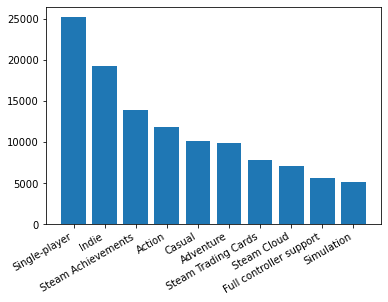

In [135]:
fig, ax = plt.subplots()

top_10_labels = sorted_labels[:10]

x = [cat[0] for cat in top_10_labels]
y = [cat[1] for cat in top_10_labels]

for label in ax.get_xticklabels():
    label.set_rotation(30)
    label.set_ha('right')

ax.bar(x, y)

In [77]:
#this is our matrix describing the content of each game
unique_encoded_df = create_mlb_df(cat_df, ['all_cats'])
unique_encoded_df

,1980s,1990's,2.5D,2D,2D Fighter,360 Video,3D,3D Platformer,3D Vision,4 Player Local,...,Warhammer 40K,Web Publishing,Werewolves,Western,Word Game,World War I,World War II,Wrestling,Zombies,e-sports
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27071,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27072,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27073,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [78]:
for col in unique_encoded_df.columns:
    print(col)

1980s
1990's
2.5D
2D
2D Fighter
360 Video
3D
3D Platformer
3D Vision
4 Player Local
4X
6DOF
Abstract
Accounting
Action
Action RPG
Action-Adventure
Adventure
Agriculture
Aliens
Alternate History
America
Animation & Modeling
Anime
Arcade
Arena Shooter
Assassin
Atmospheric
Audio Production
BMX
Base-Building
Baseball
Basketball
Batman
Battle Royale
Beat 'em up
Beautiful
Benchmark
Bikes
Blood
Board Game
Bowling
Building
Bullet Hell
Bullet Time
CRPG
Capitalism
Captions available
Card Game
Cartoon
Cartoony
Casual
Cats
Character Action Game
Character Customization
Chess
Choices Matter
Choose Your Own Adventure
Cinematic
City Builder
Class-Based
Classic
Clicker
Co-op
Cold War
Colorful
Comedy
Comic Book
Commentary available
Competitive
Controller
Conversation
Crafting
Crime
Cross-Platform Multiplayer
Cult Classic
Cute
Cyberpunk
Cycling
Dark
Dark Fantasy
Dark Humor
Dating Sim
Demons
Design & Illustration
Destruction
Detective
Difficult
Dinosaurs
Diplomacy
Documentary
Dog
Dragons
Drama
Driving
Dun

## Simple Model

This simple model is a content-based recommender system. The user provides the system with a game, and the system returns recommendations of games that are similar to the game provided. The model uses cosine similarity to determine similarity. Currently, the model only takes in a single game input and returns a specified number of games as output.

In [79]:
#picking a game to use as a test case
game = 'STAR WARS™ Republic Commando™'
steam_df[steam_df['name'] == game]

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,total_ratings,percent_positive
147,6000,STAR WARS™ Republic Commando™,2009-07-08,1,LucasArts,LucasArts;Lucasfilm;Disney Interactive,windows,0,Single-player;Multi-player;Local Multi-Player;...,Action,Star Wars;Action;FPS,0,6392,379,369,265,1000000-2000000,7.19,6771,0.944026


In [80]:
game_idx = steam_df[steam_df['name'] == game].index
game_idx

Int64Index([147], dtype='int64')

In [81]:
game_features = unique_encoded_df.loc[game_idx]
game_features

,1980s,1990's,2.5D,2D,2D Fighter,360 Video,3D,3D Platformer,3D Vision,4 Player Local,...,Warhammer 40K,Web Publishing,Werewolves,Western,Word Game,World War I,World War II,Wrestling,Zombies,e-sports
147,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
#drop the selected game from the matrix
simple_df = unique_encoded_df.drop(game_idx, axis=0)
simple_df

,1980s,1990's,2.5D,2D,2D Fighter,360 Video,3D,3D Platformer,3D Vision,4 Player Local,...,Warhammer 40K,Web Publishing,Werewolves,Western,Word Game,World War I,World War II,Wrestling,Zombies,e-sports
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27071,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27072,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27073,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
game_features.shape

(1, 364)

In [84]:
simple_df.shape

(26563, 364)

In [85]:
simple_df_T = simple_df.T
simple_df_T

,0,1,2,3,4,5,6,7,8,9,...,27065,27066,27067,27068,27069,27070,27071,27072,27073,27074
1980s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1990's,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2.5D,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2D,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2D Fighter,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
World War I,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
World War II,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Wrestling,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Zombies,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [86]:
simple_df_T.shape

(364, 26563)

In [87]:
numerators = game_features.dot(simple_df_T)
numerators

,0,1,2,3,4,5,6,7,8,9,...,27065,27066,27067,27068,27069,27070,27071,27072,27073,27074
147,4,4,3,4,4,3,5,4,3,4,...,2,1,1,1,1,1,2,4,2,2


In [88]:
denominators = np.array( [(np.linalg.norm(game_features) * np.linalg.norm(row)) for index, row in simple_df.iterrows()] )
denominators

array([6.4807407 , 6.4807407 , 5.91607978, ..., 8.36660027, 5.91607978,
       5.91607978])

In [89]:
cos_sim = numerators/denominators
cos_sim

,0,1,2,3,4,5,6,7,8,9,...,27065,27066,27067,27068,27069,27070,27071,27072,27073,27074
147,0.617213,0.617213,0.507093,0.617213,0.617213,0.507093,0.668153,0.676123,0.566947,0.478091,...,0.338062,0.142857,0.188982,0.169031,0.169031,0.169031,0.377964,0.478091,0.338062,0.338062


In [90]:
cos_sim_T = cos_sim.T
cos_sim_T

,147
0,0.617213
1,0.617213
2,0.507093
3,0.617213
4,0.617213
...,...
27070,0.169031
27071,0.377964
27072,0.478091
27073,0.338062


In [91]:
game_idx[0]

147

In [92]:
cos_sim_T.columns

Int64Index([147], dtype='int64')

In [93]:
cos_sim_T.sort_values(by=[game_idx[0]], ascending=False, inplace=True)
cos_sim_T

,147
590,0.935414
591,0.857143
592,0.845154
55,0.771517
227,0.771517
...,...
24912,0.000000
18962,0.000000
20755,0.000000
16655,0.000000


In [94]:
#number of recommendations to return
number_recs = 10

In [95]:
top_matches = cos_sim_T.head(number_recs)
top_matches

,147
590,0.935414
591,0.857143
592,0.845154
55,0.771517
227,0.771517
53,0.771517
50,0.771517
58,0.771517
46,0.771517
45,0.771517


In [96]:
top_index = top_matches.index
top_index

Int64Index([590, 591, 592, 55, 227, 53, 50, 58, 46, 45], dtype='int64')

In [97]:
#our results ordered with most similar at the top
results_df = steam_df.loc[top_index]
results_df

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,total_ratings,percent_positive
590,32380,STAR WARS™ Jedi Knight: Dark Forces II,2009-09-16,1,LucasArts,LucasArts;Lucasfilm;Disney Interactive,windows,0,Single-player;Multi-player;Local Multi-Player;...,Action,Action;Star Wars;FPS,0,777,315,141,221,1000000-2000000,4.79,1092,0.711538
591,32390,STAR WARS™ Jedi Knight - Mysteries of the Sith™,2009-09-16,1,LucasArts,LucasArts;Lucasfilm;Disney Interactive,windows,0,Single-player;Multi-player;Partial Controller ...,Action,Action;Star Wars;FPS,0,366,192,30,30,500000-1000000,2.09,558,0.655914
592,32400,STAR WARS™ - Dark Forces,2009-09-16,1,LucasArts,LucasArts;Lucasfilm;Disney Interactive,windows;mac,0,Single-player;Steam Cloud,Action,FPS;Star Wars;Action,0,1501,171,99,101,1000000-2000000,4.79,1672,0.897727
55,2350,QUAKE III: Team Arena,2007-08-03,1,id Software,id Software,windows,0,Single-player;Multi-player;Steam Cloud,Action,Action;FPS;Competitive,0,108,31,0,0,200000-500000,12.99,139,0.776978
227,9040,QUAKE Mission Pack 1: Scourge of Armagon,2007-08-03,1,Ritual Entertainment,id Software,windows,0,Single-player;Multi-player;Steam Cloud,Action,Action;FPS;Shooter,0,205,13,129,152,200000-500000,2.49,218,0.940367
53,2330,QUAKE II Mission Pack: The Reckoning,2007-08-03,1,Xatrix Entertainment,id Software,windows,0,Single-player;Multi-player;Steam Cloud,Action,Action;FPS;Classic,0,65,12,32,32,200000-500000,2.49,77,0.844156
50,2300,DOOM II,2007-08-03,1,id Software,id Software,windows,0,Single-player;Multi-player;Steam Cloud,Action,Classic;FPS;Action,0,2517,182,90,78,500000-1000000,3.99,2699,0.932568
58,2390,Heretic: Shadow of the Serpent Riders,2007-08-03,1,Raven Software,id Software,windows,0,Single-player;Multi-player;Steam Cloud,Action,Classic;Action;FPS,0,417,29,0,0,200000-500000,2.99,446,0.934978
46,2210,Quake IV,2011-08-04,1,RavenSoft / id Software,Bethesda Softworks,windows,18,Single-player;Multi-player;Steam Cloud,Action,FPS;Action;Shooter,0,891,171,36,32,200000-500000,12.99,1062,0.838983
45,2200,Quake III Arena,2007-08-03,1,id Software,id Software,windows,0,Single-player;Multi-player;Steam Cloud,Action,FPS;Action;Classic,0,1362,66,123,103,200000-500000,12.99,1428,0.953782


In [98]:
#compare to our target
steam_df[steam_df['name'] == game]

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,total_ratings,percent_positive
147,6000,STAR WARS™ Republic Commando™,2009-07-08,1,LucasArts,LucasArts;Lucasfilm;Disney Interactive,windows,0,Single-player;Multi-player;Local Multi-Player;...,Action,Star Wars;Action;FPS,0,6392,379,369,265,1000000-2000000,7.19,6771,0.944026


Next steps:
* Consolidate model into a function or group of functions
* Filter content - model currently uses all categories in data, even if some are non-game related
* Incorporate platforms - maybe a toggle for match platforms exactly or just add those in as features for similarity
* Organize output and return key information in a better format

In [109]:
def content_recommendation(game, content_matrix, df, n):
    #get the index of the game from the games info dataframe
    game_idx = df[df['name'] == game].index
    print(game_idx)
    #get the features for the game from the content matrix
    game_features = content_matrix.loc[game_idx]
    #drop the game from the content matrix
    other_games_df = content_matrix.drop(game_idx, axis=0)
    #compute cosine similarity with sklearn
    cos_sim = cosine_similarity(game_features, other_games_df)
    #transform array of cos_sims into dataframe
    cos_sim_df = pd.DataFrame(cos_sim, index=game_idx, 
                              columns=other_games_df.index).T
    cos_sim_df.sort_values(by=[game_idx[0]], ascending=False, inplace=True)
    top_matches = cos_sim_df.iloc[:n]
    print(top_matches)
    #get the index for each recommended game
    top_idx = top_matches.index
    #refer to full games info matrix to return info for recommended games
    rec_df = df.loc[top_idx]
    return rec_df

In [100]:
game='Warframe'
steam_df[steam_df['name']==game]

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,total_ratings,percent_positive
1634,230410,Warframe,2013-03-25,1,Digital Extremes,Digital Extremes,windows,16,Single-player;Multi-player;Co-op;Steam Trading...,Action;Free to Play,Free to Play;Action;Co-op,187,226541,20268,5845,394,20000000-50000000,0.0,246809,0.91788


In [101]:
game = 'Warframe'
content_recommendation(game, unique_encoded_df, steam_df, 10)

           1634
5235   0.824958
8766   0.782624
1437   0.755929
7562   0.750000
23887  0.746203
1284   0.730297
1100   0.730297
3835   0.730297
683    0.721688
3990   0.721688


,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,total_ratings,percent_positive
5235,359550,Tom Clancy's Rainbow Six® Siege,2015-12-01,1,Ubisoft Montreal,Ubisoft,windows,0,Single-player;Multi-player;Co-op;Steam Trading...,Action,FPS;Multiplayer;Tactical,0,251178,59620,7504,2543,5000000-10000000,16.99,310798,0.808171
8766,460930,Tom Clancy's Ghost Recon® Wildlands,2017-03-06,1,Ubisoft Paris;Ubisoft Annecy;Ubisoft Bucharest...,Ubisoft,windows,0,Single-player;Multi-player;Co-op;Steam Trading...,Action;Adventure,Open World;Shooter;Action,0,26547,9944,1987,1242,1000000-2000000,41.99,36491,0.727494
1437,215830,Closers,2018-02-06,1,Naddic Games,En Masse Entertainment,windows,0,Single-player;Multi-player;Online Multi-Player...,Action;Free to Play;Massively Multiplayer;RPG,Anime;Free to Play;Massively Multiplayer,0,2061,734,194,283,500000-1000000,0.00,2795,0.737388
7562,426630,Bubsy Two-Fur,2015-12-17,1,Accolade,Retroism,windows,0,Single-player;Multi-player;Co-op;Steam Trading...,Action;Adventure,Action;Adventure;Platformer,0,231,94,0,0,20000-50000,3.99,325,0.710769
23887,911260,Dawn of the Breakers,2018-11-22,1,"CyberStep, Inc.","CyberStep, Inc.",windows,0,Single-player;Multi-player;Online Multi-Player...,Action;Adventure;Free to Play;RPG,Free to Play;Adventure;RPG,0,22,29,0,0,0-20000,0.00,51,0.431373
1284,206500,AirMech Strike,2018-03-30,1,Carbon Games,Carbon Games,windows,0,Single-player;Multi-player;Online Multi-Player...,Action;Free to Play;Indie;Strategy,Free to Play;Strategy;Multiplayer,91,7640,1440,441,172,1000000-2000000,0.00,9080,0.841410
1100,99900,Spiral Knights,2011-06-14,1,"Grey Havens, LLC","Grey Havens, LLC",windows;mac,0,Single-player;Multi-player;MMO;Co-op;Steam Ach...,Action;Adventure;Casual;Free to Play;Indie;Mas...,Free to Play;Massively Multiplayer;RPG,54,15666,3202,275,64,2000000-5000000,0.00,18868,0.830295
3835,321400,Supraball,2019-02-08,1,Supra Games,Supra Games,windows,0,Single-player;Multi-player;Online Multi-Player...,Action;Casual;Free to Play;Indie;Sports,Sports;Multiplayer;Free to Play,36,1710,530,165,222,200000-500000,0.00,2240,0.763393
683,36900,Angle of Attack,2009-08-17,1,3000AD,3000AD,windows,0,Single-player;Multi-player;Co-op;Partial Contr...,Action;Simulation,Simulation;Action,0,0,2,0,0,0-20000,6.99,2,0.000000
3990,326960,Killing Floor - Toy Master,2014-10-16,1,David Hensley;Alex Quick,Tripwire Interactive,windows;mac;linux,0,Single-player;Co-op,Action,Free to Play;Horror;Multiplayer,0,21,2,1,1,500000-1000000,0.00,23,0.913043


## User Input for Content Recommender

In [102]:
def game_input(df):
    game = input('Please type the name of the game you would like recommendations for: ')
    if type(game) is str:
        game_idx = df[df['name'] == game].index
    if len(game_idx) == 0:
        return('Sorry, recommendations are not available for this game!')
    game_name = df.loc[game_idx]['name'].values[0]
    game_id = df.loc[game_idx]['appid'].values[0]
    print(f'Looking for recommendations for {game_name} (app id {game_id}):')
    return game_idx

In [103]:
def number_recs():
    n = input('How many recommendations do you want? ')
    try:
        n = int(n)
    except:
        print('Please enter a valid number.')
        n = number_recs()
    if n == 0:
        print('Please pick a nonzero number.')
        n = number_recs()
    if n > 50:
        print('Too many recommendations, please pick a smaller number.')
        n = number_recs()
    return n

In [104]:
wf_df = steam_df[steam_df['name'] == 'Warframe']
print(wf_df['name'].values[0])

Warframe


In [268]:
game_input(steam_df)

Please type the name of the game you would like recommendations for: 0


'Sorry, recommendations are not available for this game!'

In [276]:
number_recs()

How many recommendations do you want? 0
Please pick a nonzero number.
How many recommendations do you want? 101
Too many recommendations, please pick a smaller number.
How many recommendations do you want? 3


3

In [110]:
content_recommendation('Portal', unique_encoded_df, steam_df, 5)

Int64Index([17], dtype='int64')
             17
17466  0.717137
3621   0.667424
18     0.667424
16     0.667424
23     0.653197


,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,total_ratings,percent_positive
17466,717120,A Collection of Bad Moments,2018-01-12,1,Sky Trail Ltd,Sky Trail Ltd,windows,0,Single-player;Steam Achievements;Captions avai...,Action;Adventure,Adventure;Action;Puzzle,9,14,7,0,0,0-20000,2.89,21,0.666667
3621,314280,The Forgotten Ones,2014-07-17,1,Bernt Andreas Eide,Bernt Andreas Eide,windows;mac;linux,0,Single-player;Steam Achievements;Captions avai...,Action;Adventure;Free to Play;Indie,Horror;Free to Play;Adventure,12,903,601,24,24,500000-1000000,0.00,1504,0.600399
18,420,Half-Life 2: Episode Two,2007-10-10,1,Valve,Valve,windows;mac;linux,0,Single-player;Steam Achievements;Captions avai...,Action,FPS;Action;Sci-fi,22,13902,696,354,301,5000000-10000000,5.79,14598,0.952322
16,380,Half-Life 2: Episode One,2006-06-01,1,Valve,Valve,windows;mac;linux,0,Single-player;Steam Achievements;Captions avai...,Action,FPS;Action;Sci-fi,13,7908,517,281,184,5000000-10000000,5.79,8425,0.938635
23,620,Portal 2,2011-04-18,1,Valve,Valve,windows;mac;linux,0,Single-player;Co-op;Steam Achievements;Full co...,Action;Adventure,Puzzle;Co-op;First-Person,51,138220,1891,1102,520,10000000-20000000,7.19,140111,0.986504


In [112]:
def content_recommendation(game_idx, content_matrix, df, n):
    #get the index of the game from the games info dataframe
    #get the features for the game from the content matrix
    game_features = content_matrix.loc[game_idx]
    #drop the game from the content matrix
    other_games_df = content_matrix.drop(game_idx, axis=0)
    #compute cosine similarity with sklearn
    cos_sim = cosine_similarity(game_features, other_games_df)
    #transform array of cos_sims into dataframe
    cos_sim_df = pd.DataFrame(cos_sim, index=game_idx, 
                              columns=other_games_df.index).T
    cos_sim_df.sort_values(by=[game_idx[0]], ascending=False, inplace=True)
    top_matches = cos_sim_df.iloc[:n]
    print(top_matches)
    #get the index for each recommended game
    top_idx = top_matches.index
    #refer to full games info matrix to return info for recommended games
    rec_df = df.loc[top_idx]
    return rec_df

In [115]:
game_name = game_input(steam_df)
n = number_recs()
example = content_recommendation(game_name, unique_encoded_df, steam_df, n)
example

Please type the name of the game you would like recommendations for: Portal
Looking for recommendations for Portal (app id 400):
How many recommendations do you want? 5
             17
17466  0.717137
3621   0.667424
18     0.667424
16     0.667424
23     0.653197


,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,total_ratings,percent_positive
17466,717120,A Collection of Bad Moments,2018-01-12,1,Sky Trail Ltd,Sky Trail Ltd,windows,0,Single-player;Steam Achievements;Captions avai...,Action;Adventure,Adventure;Action;Puzzle,9,14,7,0,0,0-20000,2.89,21,0.666667
3621,314280,The Forgotten Ones,2014-07-17,1,Bernt Andreas Eide,Bernt Andreas Eide,windows;mac;linux,0,Single-player;Steam Achievements;Captions avai...,Action;Adventure;Free to Play;Indie,Horror;Free to Play;Adventure,12,903,601,24,24,500000-1000000,0.00,1504,0.600399
18,420,Half-Life 2: Episode Two,2007-10-10,1,Valve,Valve,windows;mac;linux,0,Single-player;Steam Achievements;Captions avai...,Action,FPS;Action;Sci-fi,22,13902,696,354,301,5000000-10000000,5.79,14598,0.952322
16,380,Half-Life 2: Episode One,2006-06-01,1,Valve,Valve,windows;mac;linux,0,Single-player;Steam Achievements;Captions avai...,Action,FPS;Action;Sci-fi,13,7908,517,281,184,5000000-10000000,5.79,8425,0.938635
23,620,Portal 2,2011-04-18,1,Valve,Valve,windows;mac;linux,0,Single-player;Co-op;Steam Achievements;Full co...,Action;Adventure,Puzzle;Co-op;First-Person,51,138220,1891,1102,520,10000000-20000000,7.19,140111,0.986504


In [ ]:
def printout_recs(rec_df):
    print()

## Testing Steam API Calls

In [1]:
!ls

README.md
SteamWebAPIKey.txt
data
notebook.ipynb
scratch_notebook.ipynb


In [2]:
key = './SteamWebAPIKey.txt'
with open(key, 'r') as file:
    key = file.read()

In [73]:
#my personal steam id
steam_id = 76561199032907135

In [5]:
f = open('./data/api_personal_account.json', 'r')
data = json.loads(f.read())
for game in data['response']['games']:
    print(game)
f.close()

{'appid': 6000, 'name': 'STAR WARSâ„¢ Republic Commando', 'playtime_forever': 291, 'img_icon_url': '73d4fd5437a5491479c7235eef64cf7d5e2c2e8e', 'playtime_windows_forever': 291, 'playtime_mac_forever': 0, 'playtime_linux_forever': 0, 'rtime_last_played': 1657320312, 'capsule_filename': 'portrait.png'}
{'appid': 32370, 'name': 'STAR WARSâ„¢: Knights of the Old Republicâ„¢', 'playtime_forever': 2746, 'img_icon_url': '018b6650c8de8c9c36d957cf6f8bc11d0c21d083', 'playtime_windows_forever': 2746, 'playtime_mac_forever': 0, 'playtime_linux_forever': 0, 'rtime_last_played': 1631947981}
{'appid': 6020, 'name': 'STAR WARSâ„¢ Jedi Knight: Jedi Academyâ„¢', 'playtime_forever': 473, 'img_icon_url': '2e359a8df71ea18ddd77fda3f6b307e6e86ef910', 'playtime_windows_forever': 473, 'playtime_mac_forever': 0, 'playtime_linux_forever': 0, 'rtime_last_played': 1657503557, 'capsule_filename': 'portrait.png', 'sort_as': 'Star Wars Jedi Knight 5'}
{'appid': 47810, 'name': 'Dragon Age: Origins - Ultimate Edition', 

In [61]:
f = open('./data/api_personal_account.json', 'r')
data = json.loads(f.read())
game_list = []
for game in data['response']['games']:
    game_list.append(game)
f.close()

In [62]:
game_list

[{'appid': 6000,
  'name': 'STAR WARSâ„¢ Republic Commando',
  'playtime_forever': 291,
  'img_icon_url': '73d4fd5437a5491479c7235eef64cf7d5e2c2e8e',
  'playtime_windows_forever': 291,
  'playtime_mac_forever': 0,
  'playtime_linux_forever': 0,
  'rtime_last_played': 1657320312,
  'capsule_filename': 'portrait.png'},
 {'appid': 32370,
  'name': 'STAR WARSâ„¢: Knights of the Old Republicâ„¢',
  'playtime_forever': 2746,
  'img_icon_url': '018b6650c8de8c9c36d957cf6f8bc11d0c21d083',
  'playtime_windows_forever': 2746,
  'playtime_mac_forever': 0,
  'playtime_linux_forever': 0,
  'rtime_last_played': 1631947981},
 {'appid': 6020,
  'name': 'STAR WARSâ„¢ Jedi Knight: Jedi Academyâ„¢',
  'playtime_forever': 473,
  'img_icon_url': '2e359a8df71ea18ddd77fda3f6b307e6e86ef910',
  'playtime_windows_forever': 473,
  'playtime_mac_forever': 0,
  'playtime_linux_forever': 0,
  'rtime_last_played': 1657503557,
  'capsule_filename': 'portrait.png',
  'sort_as': 'Star Wars Jedi Knight 5'},
 {'appid': 47

In [68]:
game_list[0]['name']

'STAR WARSâ„¢ Republic Commando'

In [ ]:
#sample format of json
{"response":
 {"game_count":44,
  "games":[{"appid":6000,"name":"STAR WARS™ Republic Commando",
            "playtime_forever":291,
            "img_icon_url":"73d4fd5437a5491479c7235eef64cf7d5e2c2e8e",
            "playtime_windows_forever":291,"playtime_mac_forever":0,
            "playtime_linux_forever":0,"rtime_last_played":1657320312,
            "capsule_filename":"portrait.png"},
           {"appid":32370,"name":"STAR WARS™: Knights of the Old Republic™",
            "playtime_forever":2746,
            "img_icon_url":"018b6650c8de8c9c36d957cf6f8bc11d0c21d083",
            "playtime_windows_forever":2746,
            "playtime_mac_forever":0,
            "playtime_linux_forever":0,
            "rtime_last_played":1631947981}
           
http://api.steampowered.com/IPlayerService/GetOwnedGames/v0001/?key=&steamid=76561199032907135&include_appinfo=1&format=json

In [67]:
sw_rc = steam_df[steam_df['appid']==6000]
sw_rc['name']

147    STAR WARS™ Republic Commando™
Name: name, dtype: object

In [70]:
steam_df[steam_df['name'].str.contains(',')]

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,total_ratings,percent_positive
133,4570,"Warhammer® 40,000: Dawn of War® - Game of the ...",2007-08-07,1,Relic Entertainment,SEGA,windows,16,Single-player;Multi-player;Steam Trading Cards...,Strategy,Strategy;Warhammer 40K;RTS,0,3485,206,309,340,1000000-2000000,9.99,3691,0.944189
134,4580,"Warhammer® 40,000: Dawn of War® - Dark Crusade",2007-08-07,1,Relic Entertainment,SEGA,windows,16,Single-player;Multi-player;Steam Cloud,Strategy,Strategy;Warhammer 40K;RTS,0,2849,133,543,620,1000000-2000000,9.99,2982,0.955399
152,6060,"Star Wars: Battlefront 2 (Classic, 2005)",2009-07-08,1,Pandemic Studios,Lucasfilm;LucasArts;Disney Interactive,windows,0,Single-player;Multi-player;Online Multi-Player...,Action,Star Wars;Action;Multiplayer,0,29149,2425,618,320,2000000-5000000,7.19,31574,0.923196
185,7210,"Runaway, A Road Adventure",2007-03-14,1,Pendulo Studios,Focus Home Interactive,windows,0,Single-player,Adventure,Adventure;Point & Click;Mystery,0,236,90,14,14,100000-200000,6.99,326,0.723926
186,7220,"Runaway, The Dream of The Turtle",2007-03-14,1,Pendulo Studios,Focus Home Interactive,windows,0,Single-player,Adventure,Adventure;Point & Click;Mystery,0,86,65,0,0,100000-200000,6.99,151,0.569536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26736,1035260,"A Game For You, Josh",2019-04-08,1,Penelope Evans,Penelope Evans,windows;mac,0,Single-player;Steam Achievements,Indie,Indie,6,1,0,0,0,0-20000,2.09,1,1.000000
26988,1053040,"Zom-bie, or Not Zom-bie",2019-04-17,1,John Michael O'Brien II;Games Master Mind,Games Master Mind,windows,0,Single-player;Steam Achievements,Indie;RPG,RPG;Indie;Action,25,2,1,0,0,0-20000,0.79,3,0.666667
27044,1058940,"Treasure Masters, Inc.: The Lost City",2019-04-02,1,Casa Games,Alawar Entertainment,windows,0,Single-player;Steam Cloud,Adventure;Casual;Indie,Adventure;Indie;Casual,0,1,1,0,0,0-20000,5.19,2,0.500000
27055,1060770,"Die, zombie sausage, die!",2019-04-24,1,AuroraCorp,Aurora software,windows,0,Single-player;Steam Leaderboards,Action;Indie;Early Access,Early Access;Action;Indie,0,1,0,0,0,0-20000,0.79,1,1.000000


In [74]:
steam_id

76561199032907135

In [ ]:
76_561_199_032_907_135
76_561_198_045_426_389

In [204]:
#testing random steam ids to get library data
rng = np.random.RandomState(42)
random_ids = rng.randint(0, 999_000_000, size=1_000)
random_ids = [76_561_199_000_000_000 + i for i in random_ids]
random_ids

[76561199534895718,
 76561199199900595,
 76561199862061404,
 76561199787846414,
 76561199996406378,
 76561199127521863,
 76561199423734972,
 76561199415968276,
 76561199670094950,
 76561199841095289,
 76561199669991378,
 76561199429389014,
 76561199249467210,
 76561199898717130,
 76561199498972759,
 76561199359525748,
 76561199434285667,
 76561199613608295,
 76561199893664919,
 76561199648061058,
 76561199088409749,
 76561199242285876,
 76561199944505601,
 76561199953477463,
 76561199354088427,
 76561199809827741,
 76561199911989541,
 76561199003344769,
 76561199780932287,
 76561199787716372,
 76561199504579232,
 76561199232968651,
 76561199479546681,
 76561199106328085,
 76561199030349564,
 76561199781447915,
 76561199099052376,
 76561199177077808,
 76561199106406362,
 76561199480404538,
 76561199643647998,
 76561199599121577,
 76561199200427519,
 76561199181009883,
 76561199961022651,
 76561199499770319,
 76561199885063869,
 76561199389151677,
 76561199151079598,
 76561199508464061,


In [113]:
players = {}
for id in random_ids:
    api_call = f'http://api.steampowered.com/IPlayerService/GetOwnedGames/v0001/?key={key}&steamid={id}&include_appinfo=1&format=json'
    player_data = requests.get(api_call).json()
    players[id] = player_data

In [114]:
players

[{'response': {}},
 {'response': {}},
 {'response': {}},
 {'response': {}},
 {'response': {}},
 {'response': {'game_count': 2,
   'games': [{'appid': 730,
     'name': 'Counter-Strike: Global Offensive',
     'playtime_forever': 19629,
     'img_icon_url': '69f7ebe2735c366c65c0b33dae00e12dc40edbe4',
     'has_community_visible_stats': True,
     'playtime_windows_forever': 18559,
     'playtime_mac_forever': 0,
     'playtime_linux_forever': 0,
     'rtime_last_played': 1658218971},
    {'appid': 880940,
     'name': 'Pummel Party',
     'playtime_forever': 132,
     'img_icon_url': 'b2261da6c4f14808955181d9b41fdc242685a325',
     'has_community_visible_stats': True,
     'playtime_windows_forever': 132,
     'playtime_mac_forever': 0,
     'playtime_linux_forever': 0,
     'rtime_last_played': 1614804265}]}},
 {'response': {}},
 {'response': {}},
 {'response': {}},
 {'response': {}},
 {'response': {}},
 {'response': {}},
 {'response': {'game_count': 1,
   'games': [{'appid': 730,
    

In [116]:
type(players[0])

dict

In [138]:
empty_dict = {}
players_dict = {}
for i in range(len(random_ids)):
    if players[i]['response'] != empty_dict:
        if players[i]['response']['game_count'] != 0:
            players_dict[random_ids[i]] = players[i]['response']
players_dict

{76561199127521863: {'game_count': 2,
  'games': [{'appid': 730,
    'name': 'Counter-Strike: Global Offensive',
    'playtime_forever': 19629,
    'img_icon_url': '69f7ebe2735c366c65c0b33dae00e12dc40edbe4',
    'has_community_visible_stats': True,
    'playtime_windows_forever': 18559,
    'playtime_mac_forever': 0,
    'playtime_linux_forever': 0,
    'rtime_last_played': 1658218971},
   {'appid': 880940,
    'name': 'Pummel Party',
    'playtime_forever': 132,
    'img_icon_url': 'b2261da6c4f14808955181d9b41fdc242685a325',
    'has_community_visible_stats': True,
    'playtime_windows_forever': 132,
    'playtime_mac_forever': 0,
    'playtime_linux_forever': 0,
    'rtime_last_played': 1614804265}]},
 76561199249467210: {'game_count': 1,
  'games': [{'appid': 730,
    'name': 'Counter-Strike: Global Offensive',
    'playtime_forever': 18,
    'img_icon_url': '69f7ebe2735c366c65c0b33dae00e12dc40edbe4',
    'has_community_visible_stats': True,
    'playtime_windows_forever': 18,
    

In [117]:
empty_dict={}
print(players[0])
players[0]['response'] == empty_dict

{'response': {}}


True

In [132]:
count=0
players_with_data = []
for player in players:
    if player['response'] != empty_dict:
        players_with_data.append(player)
        count += 1
print(count)

36


In [133]:
players_with_data

[{'response': {'game_count': 2,
   'games': [{'appid': 730,
     'name': 'Counter-Strike: Global Offensive',
     'playtime_forever': 19629,
     'img_icon_url': '69f7ebe2735c366c65c0b33dae00e12dc40edbe4',
     'has_community_visible_stats': True,
     'playtime_windows_forever': 18559,
     'playtime_mac_forever': 0,
     'playtime_linux_forever': 0,
     'rtime_last_played': 1658218971},
    {'appid': 880940,
     'name': 'Pummel Party',
     'playtime_forever': 132,
     'img_icon_url': 'b2261da6c4f14808955181d9b41fdc242685a325',
     'has_community_visible_stats': True,
     'playtime_windows_forever': 132,
     'playtime_mac_forever': 0,
     'playtime_linux_forever': 0,
     'rtime_last_played': 1614804265}]}},
 {'response': {'game_count': 1,
   'games': [{'appid': 730,
     'name': 'Counter-Strike: Global Offensive',
     'playtime_forever': 18,
     'img_icon_url': '69f7ebe2735c366c65c0b33dae00e12dc40edbe4',
     'has_community_visible_stats': True,
     'playtime_windows_forev

### Making API Calls

In [6]:
#testing random steam ids to get library data
rng = np.random.RandomState(42)
random_ids = rng.randint(0, 999_000_000, size=1_000)
random_ids = [76_561_198_000_000_000 + i for i in random_ids]
random_ids

[76561198534895718,
 76561198199900595,
 76561198862061404,
 76561198787846414,
 76561198996406378,
 76561198127521863,
 76561198423734972,
 76561198415968276,
 76561198670094950,
 76561198841095289,
 76561198669991378,
 76561198429389014,
 76561198249467210,
 76561198898717130,
 76561198498972759,
 76561198359525748,
 76561198434285667,
 76561198613608295,
 76561198893664919,
 76561198648061058,
 76561198088409749,
 76561198242285876,
 76561198944505601,
 76561198953477463,
 76561198354088427,
 76561198809827741,
 76561198911989541,
 76561198003344769,
 76561198780932287,
 76561198787716372,
 76561198504579232,
 76561198232968651,
 76561198479546681,
 76561198106328085,
 76561198030349564,
 76561198781447915,
 76561198099052376,
 76561198177077808,
 76561198106406362,
 76561198480404538,
 76561198643647998,
 76561198599121577,
 76561198200427519,
 76561198181009883,
 76561198961022651,
 76561198499770319,
 76561198885063869,
 76561198389151677,
 76561198151079598,
 76561198508464061,


In [7]:
players = {}
for id in random_ids:
    api_call = f'http://api.steampowered.com/IPlayerService/GetOwnedGames/v0001/?key={key}&steamid={id}&include_appinfo=1&format=json'
    player_data = requests.get(api_call).json()
    players[id] = player_data

In [8]:
players

{76561198534895718: {'response': {}},
 76561198199900595: {'response': {'game_count': 24,
   'games': [{'appid': 4000,
     'name': "Garry's Mod",
     'playtime_forever': 2648,
     'img_icon_url': '4a6f25cfa2426445d0d9d6e233408de4d371ce8b',
     'has_community_visible_stats': True,
     'playtime_windows_forever': 0,
     'playtime_mac_forever': 0,
     'playtime_linux_forever': 0,
     'rtime_last_played': 1559592042},
    {'appid': 200210,
     'name': 'Realm of the Mad God Exalt',
     'playtime_forever': 67,
     'img_icon_url': '76c62602486e58f9501e09e7e8f189e86823e8d5',
     'has_community_visible_stats': True,
     'playtime_windows_forever': 0,
     'playtime_mac_forever': 0,
     'playtime_linux_forever': 0,
     'rtime_last_played': 1565631924},
    {'appid': 253710,
     'name': 'theHunter Classic',
     'playtime_forever': 0,
     'img_icon_url': '4a91dc770675e559038a4f46e0daa4f8fa42ee30',
     'has_community_visible_stats': True,
     'playtime_windows_forever': 0,
     

In [11]:
empty_dict = {}
players_dict = {}
for account in random_ids:
    if players[account]['response'] != empty_dict:
        if players[account]['response']['game_count'] != 0:
            players_dict[account] = players[account]['response']
players_dict

{76561198199900595: {'game_count': 24,
  'games': [{'appid': 4000,
    'name': "Garry's Mod",
    'playtime_forever': 2648,
    'img_icon_url': '4a6f25cfa2426445d0d9d6e233408de4d371ce8b',
    'has_community_visible_stats': True,
    'playtime_windows_forever': 0,
    'playtime_mac_forever': 0,
    'playtime_linux_forever': 0,
    'rtime_last_played': 1559592042},
   {'appid': 200210,
    'name': 'Realm of the Mad God Exalt',
    'playtime_forever': 67,
    'img_icon_url': '76c62602486e58f9501e09e7e8f189e86823e8d5',
    'has_community_visible_stats': True,
    'playtime_windows_forever': 0,
    'playtime_mac_forever': 0,
    'playtime_linux_forever': 0,
    'rtime_last_played': 1565631924},
   {'appid': 253710,
    'name': 'theHunter Classic',
    'playtime_forever': 0,
    'img_icon_url': '4a91dc770675e559038a4f46e0daa4f8fa42ee30',
    'has_community_visible_stats': True,
    'playtime_windows_forever': 0,
    'playtime_mac_forever': 0,
    'playtime_linux_forever': 0,
    'rtime_last_